In [64]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import sklearn as sk
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions, MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

import os

In [122]:
def process_image(image_path):
    image = load_img(image_path, target_size=(224,224))
    image_array = img_to_array(image)
    image_batch = np.expand_dims(image_array, axis=0)
    processed_image = preprocess_input(image_batch)
    return processed_image

def predict_image_class(model, preprocessed_image):
    raw_prediction = model.predict(preprocessed_image, verbose=0)
    print(raw_prediction.shape)
    decoded_prediction = decode_predictions(raw_prediction)[0]
    df = pd.DataFrame(data={
        'image_class': [_[1] for _ in decoded_prediction],
        'probability': [_[2] for _ in decoded_prediction]
    })
    return df

In [46]:
PRETRAINED_MODEL = MobileNetV2(weights='imagenet')

In [47]:
PRETRAINED_MODEL.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [48]:
base_path = 'data/train'
CLASSES = [f for f in os.listdir(base_path) if not f.startswith('.')]
CLASSES

['spoons', 'books', 'forks', 'shoes']

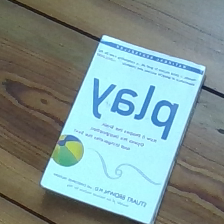

In [49]:
load_img(f'{base_path}/books/09-17-23-494963.png')

In [123]:
predict_image_class(PRETRAINED_MODEL, process_image(f'{base_path}/books/09-17-23-494963.png'))

(1, 1000)


,image_class,probability
0,carton,0.471277
1,packet,0.120985
2,crate,0.100162
3,pick,0.026904
4,envelope,0.015834


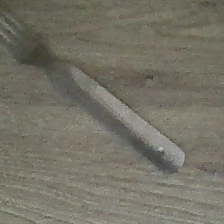

In [51]:
load_img(f'{base_path}/forks/09-25-41-950661.png')

In [33]:
predict_image_class(PRETRAINED_MODEL, process_image(f'{base_path}/forks/09-25-41-950661.png'))

,image_class,probability
0,spatula,0.108380
1,nail,0.095838
2,letter_opener,0.089620
3,hammer,0.061375
4,ladle,0.049651


In [52]:
image_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [53]:
train_image_data = image_data_generator.flow_from_directory(
    directory=base_path,
    class_mode='categorical',
    classes=CLASSES,
    batch_size=400,
    target_size=(224, 224)
)

Found 400 images belonging to 4 classes.


In [54]:
Xtrain, ytrain = next(train_image_data)
Xtrain.shape, ytrain.shape

((400, 224, 224, 3), (400, 4))

In [94]:
BASE_MODEL = MobileNetV2(
    weights='imagenet',
    alpha=1.0,
    include_top=False,
    pooling='avg',
    input_shape=(224,224,3)
)

BASE_MODEL.trainable = False

In [95]:
BASE_MODEL.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [96]:
def build_hypermodel(hyperparameters):
    model = Sequential()
    model.add(BASE_MODEL)
    # tune number of neurons in first dense layer
    units = hyperparameters.Choice(
        'units', 
        values=[1280,640,320,160,80],
    )
    # first dense layer
    model.add(
        Dense(
            units=units, 
            activation='relu'
        )
    )
    # second layer (dropout layer) 
    model.add(
        Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    # tune learning rate for the optimizer
    learning_rate = hyperparameters.Choice(
        'learning_rate', 
        values=[1e-2, 1e-3, 1e-4]
    )
    # compile model
    model.compile(
        optimizer=Adam(
            learning_rate=learning_rate
        ),
        loss=categorical_crossentropy,
        metrics=[categorical_accuracy]
    )

    return model

In [97]:
tuner = kt.Hyperband(
    hypermodel=build_hypermodel,
    objective='val_categorical_accuracy',
    max_epochs=50,
    hyperband_iterations=3,
    project_name='data/kt_files'
)

# hypertuning settings
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./data/kt_files/oracle.json
INFO:tensorflow:Reloading Tuner from ./data/kt_files/tuner0.json
Search space summary
Default search space size: 2
units (Choice)
{'default': 1280, 'conditions': [], 'values': [1280, 640, 320, 160, 80], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [98]:
early_stop_callback = EarlyStopping(
    monitor='val_loss', 
    patience=5
)

tuner.search(Xtrain, ytrain,epochs=100, callbacks=[early_stop_callback], validation_split=0.2)

INFO:tensorflow:Oracle triggered exit


In [99]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [100]:
best_hyperparameters.get('units')

80

In [101]:
best_hyperparameters.get('learning_rate')

0.001

In [102]:
best_hypermodel = tuner.hypermodel.build(best_hyperparameters)
best_hypermodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_6 (Dense)              (None, 80)                102480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 324       
Total params: 2,360,788
Trainable params: 102,804
Non-trainable params: 2,257,984
_________________________________________________________________


In [103]:
best_hypermodel.fit(Xtrain, ytrain,
    epochs=50,
    batch_size=20,
    callbacks=[early_stop_callback],
    validation_split=0.2
)

Epoch 1/50


2022-10-28 13:35:45.057911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 1.0124 - categorical_accuracy: 0.6062

2022-10-28 13:35:46.329454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 2s 76ms/step - loss: 1.0124 - categorical_accuracy: 0.6062 - val_loss: 0.4442 - val_categorical_accuracy: 0.8250
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.3437 - categorical_accuracy: 0.8906 - val_loss: 0.2395 - val_categorical_accuracy: 0.9250
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.1632 - categorical_accuracy: 0.9500 - val_loss: 0.1582 - val_categorical_accuracy: 0.9375
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.1206 - categorical_accuracy: 0.9719 - val_loss: 0.1543 - val_categorical_accuracy: 0.9500
Epoch 5/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0931 - categorical_accuracy: 0.9844 - val_loss: 0.1239 - val_categorical_accuracy: 0.9500
Epoch 6/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0637 - categorical_accuracy: 0.9844 - val_loss: 0.1154 - val_categorical_accuracy: 0.9625
Epoch 7/50
16/16 [===

In [104]:
# losses in the training history
losses = pd.DataFrame(best_hypermodel.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

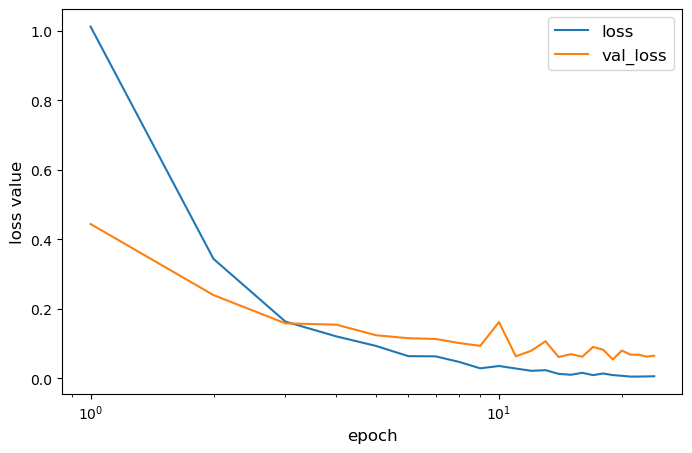

In [105]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,5),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=12)
plt.ylabel('loss value',fontsize=12)
plt.legend(loc=1,fontsize=12);

In [106]:
def calculate_image_class_probabilities(model, preprocessed_image):
    probabilities = model.predict(
        preprocessed_image,
        verbose=0
    )
    probabilities = np.round(probabilities,6)[0].tolist()
    class_probabilities = {
        k:v for (k,v) in zip(CLASSES, probabilities)
    }
    return class_probabilities

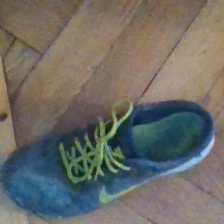

In [107]:
load_img(f'{base_path}/shoes/09-20-38-769381.png')

In [108]:
calculate_image_class_probabilities(best_hypermodel, process_image(f'{base_path}/shoes/09-20-38-769381.png'))

2022-10-28 13:36:35.820816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


{'spoons': 0.0003100000030826777,
 'books': 6.000000212225132e-06,
 'forks': 7.000000096013537e-06,
 'shoes': 0.9996780157089233}

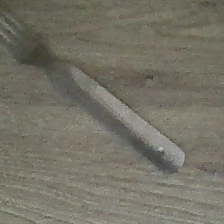

In [109]:
load_img(f'{base_path}/forks/09-25-41-950661.png')

In [110]:
calculate_image_class_probabilities(best_hypermodel, process_image(f'{base_path}/forks/09-25-41-950661.png'))

{'spoons': 0.14127300679683685,
 'books': 0.00020500000391621143,
 'forks': 0.8582389950752258,
 'shoes': 0.00028300000121816993}

In [111]:
test_image_data = image_data_generator.flow_from_directory(
    directory='data/test',
    class_mode='categorical',
    classes=CLASSES,
    target_size=(224, 224)
)

Found 39 images belonging to 4 classes.


In [112]:
Xtest, ytest = next(test_image_data)
Xtest.shape, ytest.shape

((32, 224, 224, 3), (32, 4))

In [113]:
def transfer_learning_prediction(model,x,y):
    """
    This function returns a dataframe with class probabilities
    along with true class label 
    """
    # convert vectorized classes into strings
    y = [''.join([i*j for (i,j) in zip(CLASSES,vector)]) for vector in y.astype(int)]
    # prediction dataframe along with true class
    prediction_df = pd.DataFrame(
        columns=CLASSES,
        data=np.round(model.predict(x,verbose=0),6)
    )
    prediction_df['class'] = y
    return prediction_df

In [114]:
transfer_learning_prediction(best_hypermodel, Xtest, ytest)

2022-10-28 13:37:08.240010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


,spoons,books,forks,shoes,class
0,0.999685,0.000005,0.000286,0.000025,spoons
1,0.331766,0.000020,0.667251,0.000963,forks
2,0.000039,0.999913,0.000017,0.000032,books
3,0.000759,0.000174,0.000485,0.998582,shoes
4,0.000372,0.004963,0.002402,0.992263,shoes
5,0.931096,0.031395,0.035691,0.001818,spoons
6,0.996091,0.000092,0.002954,0.000863,spoons
7,0.000273,0.000002,0.999542,0.000183,forks
8,0.000166,0.000212,0.000213,0.999410,shoes
9,0.000007,0.999956,0.000029,0.000008,books


In [115]:
def accuracy_score(model,x,y):
    "This function spits out multi-class accuracy"
    grouped_pred_df = transfer_learning_prediction(
        model,x,y
    ).groupby('class').sum()
    grouped_pred_df = grouped_pred_df.reindex(
        columns=sorted(grouped_pred_df.columns)
    )
    correct_pred = sum([grouped_pred_df.loc[class_][class_] for class_ in grouped_pred_df.index])
    accuracy_score = correct_pred/np.array(grouped_pred_df).sum()
    accuracy_score = round(accuracy_score,6)
    return accuracy_score

In [118]:
accuracy_score(best_hypermodel,Xtrain,ytrain)

0.990582

In [119]:
accuracy_score(best_hypermodel,Xtest,ytest)

0.949184